### Imagine you have DKK 500,000 saved in your bank account and you’re considering investing in either cryptocurrency or stocks. You’ve chosen Ethereum over Bitcoin due to its cost advantage.
### You’re unsure which individual stocks to pick, but you have data on the S&P 500 (Standard & Poor’s 500), a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. You’ve opted for this data instead of individual stock data because the S&P 500 is commonly used as a benchmark to measure the performance of individual stocks and investment portfolios.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import xgboost as xgb


In [3]:
ethereum = pd.read_excel('ethereum.xlsx', sheet_name='Data')
spx = pd.read_csv('spx.csv')

In [4]:
ethereum.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,"Ethereum ETH/USD price history up until Mar 2,...",NaN
2,NaN,"Ethereum (ETH) price per day from June 7, 2022...",NaN
3,NaN,NaN,NaN
4,NaN,"Jun 7, 2022",1814.05


In [5]:

ethereum = ethereum.iloc[4:1001,[1,2]]
ethereum = ethereum.reset_index(drop=True)
ethereum = ethereum.rename(columns={'Unnamed: 1':'date',
                                    'Unnamed: 2':'price'})
ethereum['date'] = pd.to_datetime(ethereum['date'], errors='coerce')
ethereum

,date,price
0,2022-06-07,1814.05
1,2022-06-08,1793.57
2,2022-06-09,1789.83
3,2022-06-10,1665.04
4,2022-06-11,1529.66
...,...,...
992,2025-02-23,2821.31
993,2025-02-24,2513.82
994,2025-02-25,2493.59
995,2025-02-26,2331.45


In [6]:
ethereum.isna().sum()

date     0
price    0
dtype: int64

In [7]:
spx.head()

,Date,Close/Last,Open,High,Low
0,02/28/2025,5954.50,5856.74,5959.40,5837.66
1,02/27/2025,5861.57,5981.88,5993.69,5858.78
2,02/26/2025,5956.06,5970.87,6009.82,5932.69
3,02/25/2025,5955.25,5982.73,5992.65,5908.49
4,02/24/2025,5983.25,6026.69,6043.65,5977.83


In [8]:
spx = spx.iloc[:,[0,1]]
spx['Date'] = pd.to_datetime(spx['Date'], errors='coerce')
spx = spx[(spx.Date >='2022-02-28') & (spx.Date <='2025-02-28')]
spx = spx.sort_values(by='Date',ascending=True)
spx = spx.reset_index(drop=True)
spx = spx.rename(columns={'Date':'date',
                          'Close/Last':'price'})

#### Ensure that the spx dataset has a continuous daily date range, even for missing weekends, by filling in missing dates with the most recent available data (Friday's data).

In [9]:
# Ensure 'date' is set as the index to allow resampling
spx = spx.set_index('date')

# Create a full daily date range from the minimum to the maximum date in SPX
full_date_range = pd.date_range(start=spx.index.min(), end=spx.index.max(), freq='D')

# Reindex SPX to have a continuous 7-day week dataset, filling missing dates (weekends) with previous available data (Friday's data)
spx = spx.reindex(full_date_range, method='ffill')

# Reset index to return 'date' as a column
spx = spx.reset_index().rename(columns={'index': 'date'})

In [10]:
spx.head(20)

,date,price
0,2022-02-28,4373.94
1,2022-03-01,4306.26
2,2022-03-02,4386.54
3,2022-03-03,4363.49
4,2022-03-04,4328.87
5,2022-03-05,4328.87
6,2022-03-06,4328.87
7,2022-03-07,4201.09
8,2022-03-08,4170.70
9,2022-03-09,4277.88


In [11]:
spx.isna().sum()

date     0
price    0
dtype: int64

## Q1. Where to invest (e.g., cryptocurrency or stock)?

#### Price trends of ETH and S&P500

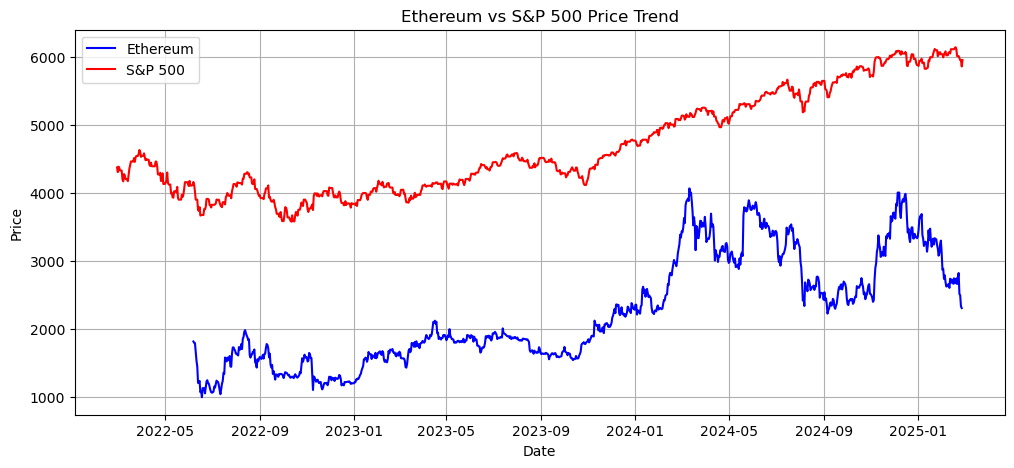

In [12]:
plt.figure(figsize=(12,5))
plt.plot(ethereum["date"], ethereum["price"], label="Ethereum", color="blue")
plt.plot(spx["date"], spx["price"], label="S&P 500", color="red")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Ethereum vs S&P 500 Price Trend")
plt.legend()
plt.grid(True)

plt.show()

#### Calculate the Return on Investment (RoI) for the two datasets across different time periods: total, annualized, daily, monthly, and yearly RoI.

In [13]:
def roi(data, date_col, price_col):

    # Total RoI
    initial_price = data[price_col].iloc[0]
    final_price = data[price_col].iloc[-1]
    total_roi = ((final_price - initial_price) / initial_price) * 100

    # Annualized RoI
    days_in_period = (data[date_col].iloc[-1] - data[date_col].iloc[0]).days
    years_in_period = days_in_period / 365.25
    annualized_roi = (final_price / initial_price) ** (1 / years_in_period) - 1
    annualized_roi_percent = annualized_roi * 100

    # Daily RI
    data['Daily_RoI'] = data[price_col].pct_change() * 100

    # Monthly RoI
    data['YearMonth'] = data[date_col].dt.to_period('M')
    monthly_roi = data.groupby('YearMonth').agg({price_col: ['first', 'last']})
    monthly_roi['Monthly_RoI'] = (monthly_roi[price_col]['last'] - monthly_roi[price_col]['first']) / monthly_roi[price_col]['first'] * 100

    # Yearly RoI
    data['Year'] = data[date_col].dt.to_period('Y')
    yearly_roi = data.groupby('Year').agg({price_col: ['first', 'last']})
    yearly_roi['Yearly_RoI'] = (yearly_roi[price_col]['last'] - yearly_roi[price_col]['first']) / yearly_roi[price_col]['first'] * 100

    # RoI summary
    roi_summary = {
        'Total_RoI': total_roi,
        'Annualized_RoI': annualized_roi_percent,
        'Daily_RoI': data[['date', 'Daily_RoI']], 
        'Monthly_RoI': monthly_roi[['Monthly_RoI']], 
        'Yearly_RoI': yearly_roi[['Yearly_RoI']],  
    }

    return roi_summary

In [14]:
ethereum_cleaned = ethereum.copy()
ethereum_roi = roi(ethereum_cleaned, 'date', 'price')
ethereum_roi

{'Total_RoI': 27.09021250792426,
 'Annualized_RoI': 9.189195296648789,
 'Daily_RoI':           date  Daily_RoI
 0   2022-06-07        NaN
 1   2022-06-08  -1.128966
 2   2022-06-09  -0.208523
 3   2022-06-10  -6.972171
 4   2022-06-11  -8.130736
 ..         ...        ...
 992 2025-02-23   2.072336
 993 2025-02-24 -10.898838
 994 2025-02-25  -0.804751
 995 2025-02-26  -6.502272
 996 2025-02-27  -1.113899
 
 [997 rows x 2 columns],
 'Monthly_RoI':           Monthly_RoI
                      
 YearMonth            
 2022-06    -41.164797
 2022-07     58.668390
 2022-08     -4.985323
 2022-09    -16.278102
 2022-10     19.904090
 2022-11    -17.978730
 2022-12     -6.229089
 2023-01     32.105982
 2023-02     -2.186029
 2023-03      9.533915
 2023-04      3.476564
 2023-05      2.302465
 2023-06      3.812158
 2023-07     -3.554560
 2023-08    -12.082018
 2023-09      2.620219
 2023-10      4.766958
 2023-11     11.123984
 2023-12      9.310827
 2024-01     -2.966846
 2024-02     45.05994

#### Visualize the RoI outputs

In [15]:
def visualize_roi(roi_summary):
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    daily_roi = roi_summary['Daily_RoI'].dropna()
    axes[0].plot(daily_roi['date'], daily_roi['Daily_RoI'], color='blue', linewidth=1)
    axes[0].set_title("Daily ROI Over Time", fontsize=14)
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Daily ROI (%)")

    monthly_roi = roi_summary['Monthly_RoI'].reset_index()
    sns.barplot(data=monthly_roi, x="YearMonth", y="Monthly_RoI", hue="YearMonth", ax=axes[1], palette="Blues_r", legend=False)
    axes[1].set_title("Monthly ROI", fontsize=14)
    axes[1].set_xlabel("Year-Month")
    axes[1].set_ylabel("Monthly ROI (%)")
    axes[1].tick_params(axis='x', rotation=45)

    yearly_roi = roi_summary['Yearly_RoI'].reset_index()
    sns.barplot(data=yearly_roi, x="Year", y="Yearly_RoI", hue="Year", ax=axes[2], palette="Greens_r", legend=False)
    axes[2].set_title("Yearly ROI", fontsize=14)
    axes[2].set_xlabel("Year")
    axes[2].set_ylabel("Yearly ROI (%)")

    plt.tight_layout()
    plt.show()

    print(f"Total ROI: {roi_summary['Total_RoI']:.2f}%")
    print(f"Annualized ROI: {roi_summary['Annualized_RoI']:.2f}%")

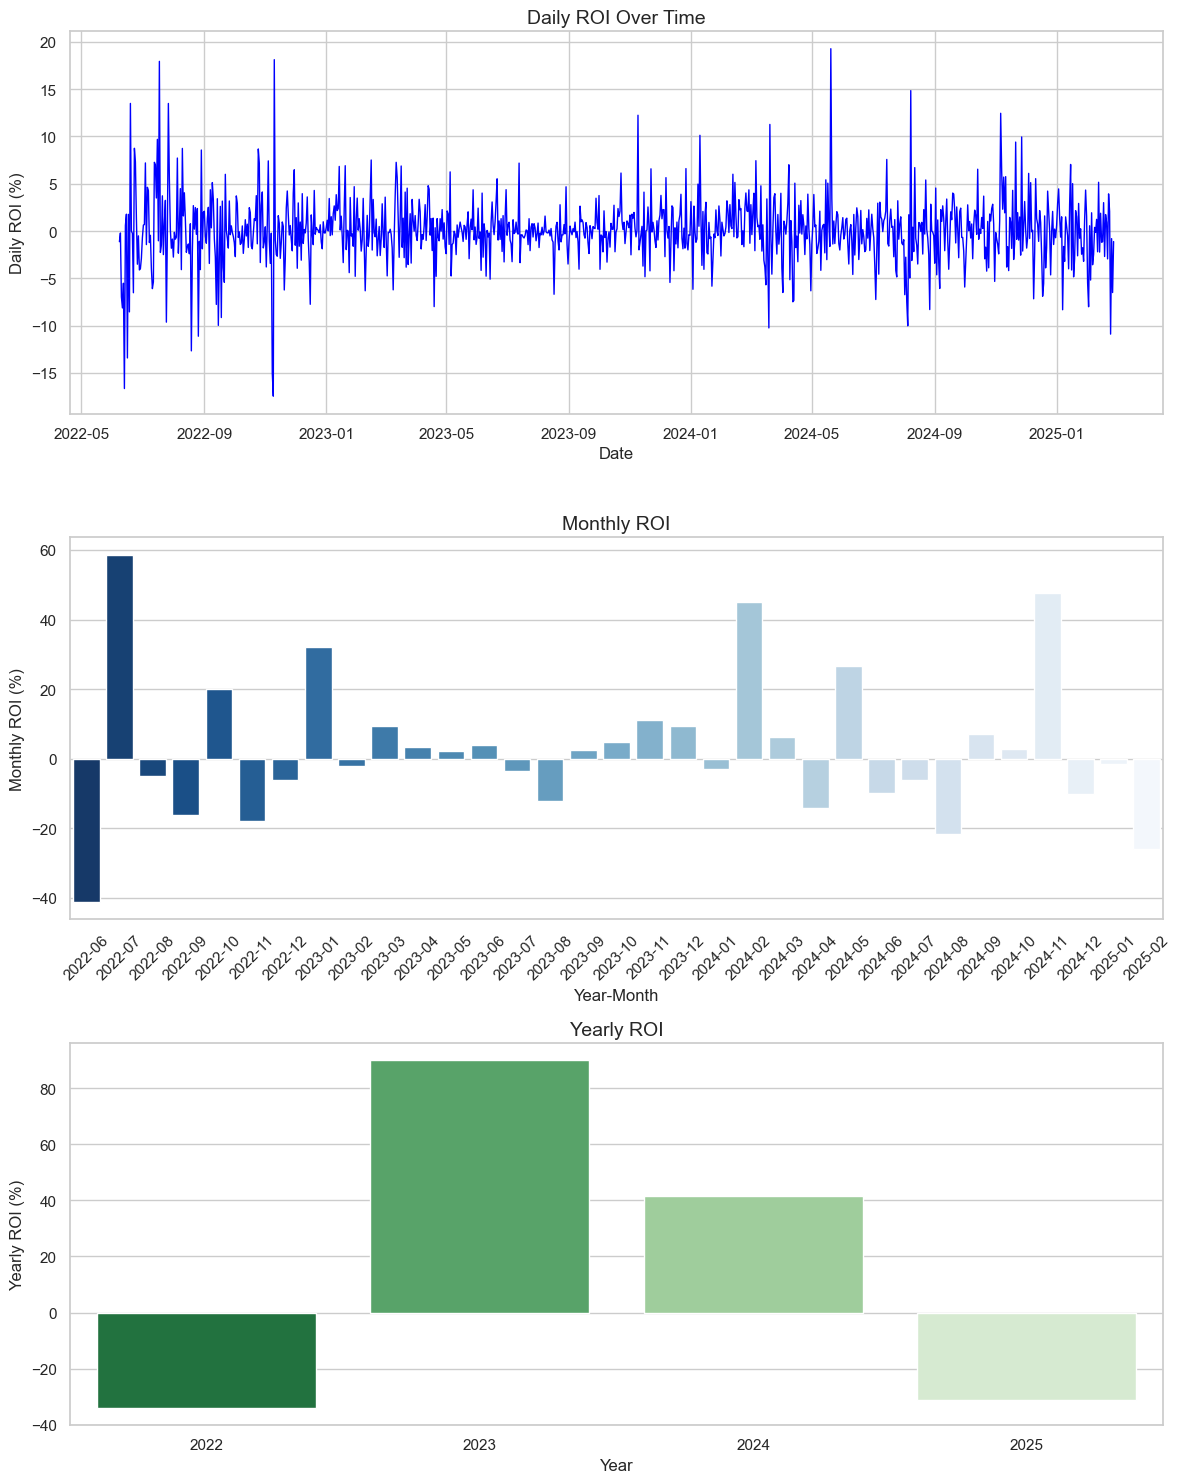

Total ROI: 27.09%
Annualized ROI: 9.19%


In [16]:
visualize_roi(ethereum_roi)

In [17]:
spx_cleaned =spx.copy()
spx_roi = roi(spx_cleaned, 'date', 'price')
spx_roi


{'Total_RoI': 36.13584091231248,
 'Annualized_RoI': 10.827441202500454,
 'Daily_RoI':            date  Daily_RoI
 0    2022-02-28        NaN
 1    2022-03-01  -1.547346
 2    2022-03-02   1.864263
 3    2022-03-03  -0.525471
 4    2022-03-04  -0.793402
 ...         ...        ...
 1092 2025-02-24  -0.496913
 1093 2025-02-25  -0.467973
 1094 2025-02-26   0.013601
 1095 2025-02-27  -1.586451
 1096 2025-02-28   1.585411
 
 [1097 rows x 2 columns],
 'Monthly_RoI':           Monthly_RoI
                      
 YearMonth            
 2022-02      0.000000
 2022-03      5.205213
 2022-04     -9.105648
 2022-05      0.005324
 2022-06     -7.701348
 2022-07      7.972123
 2022-08     -3.972923
 2022-09     -9.610396
 2022-10      7.986345
 2022-11      5.809237
 2022-12     -5.815428
 2023-01      6.175283
 2023-02     -3.618655
 2023-03      3.996568
 2023-04      1.464236
 2023-05      0.286957
 2023-06      5.433758
 2023-07      3.113891
 2023-08     -1.509156
 2023-09     -5.042772
 2023-1

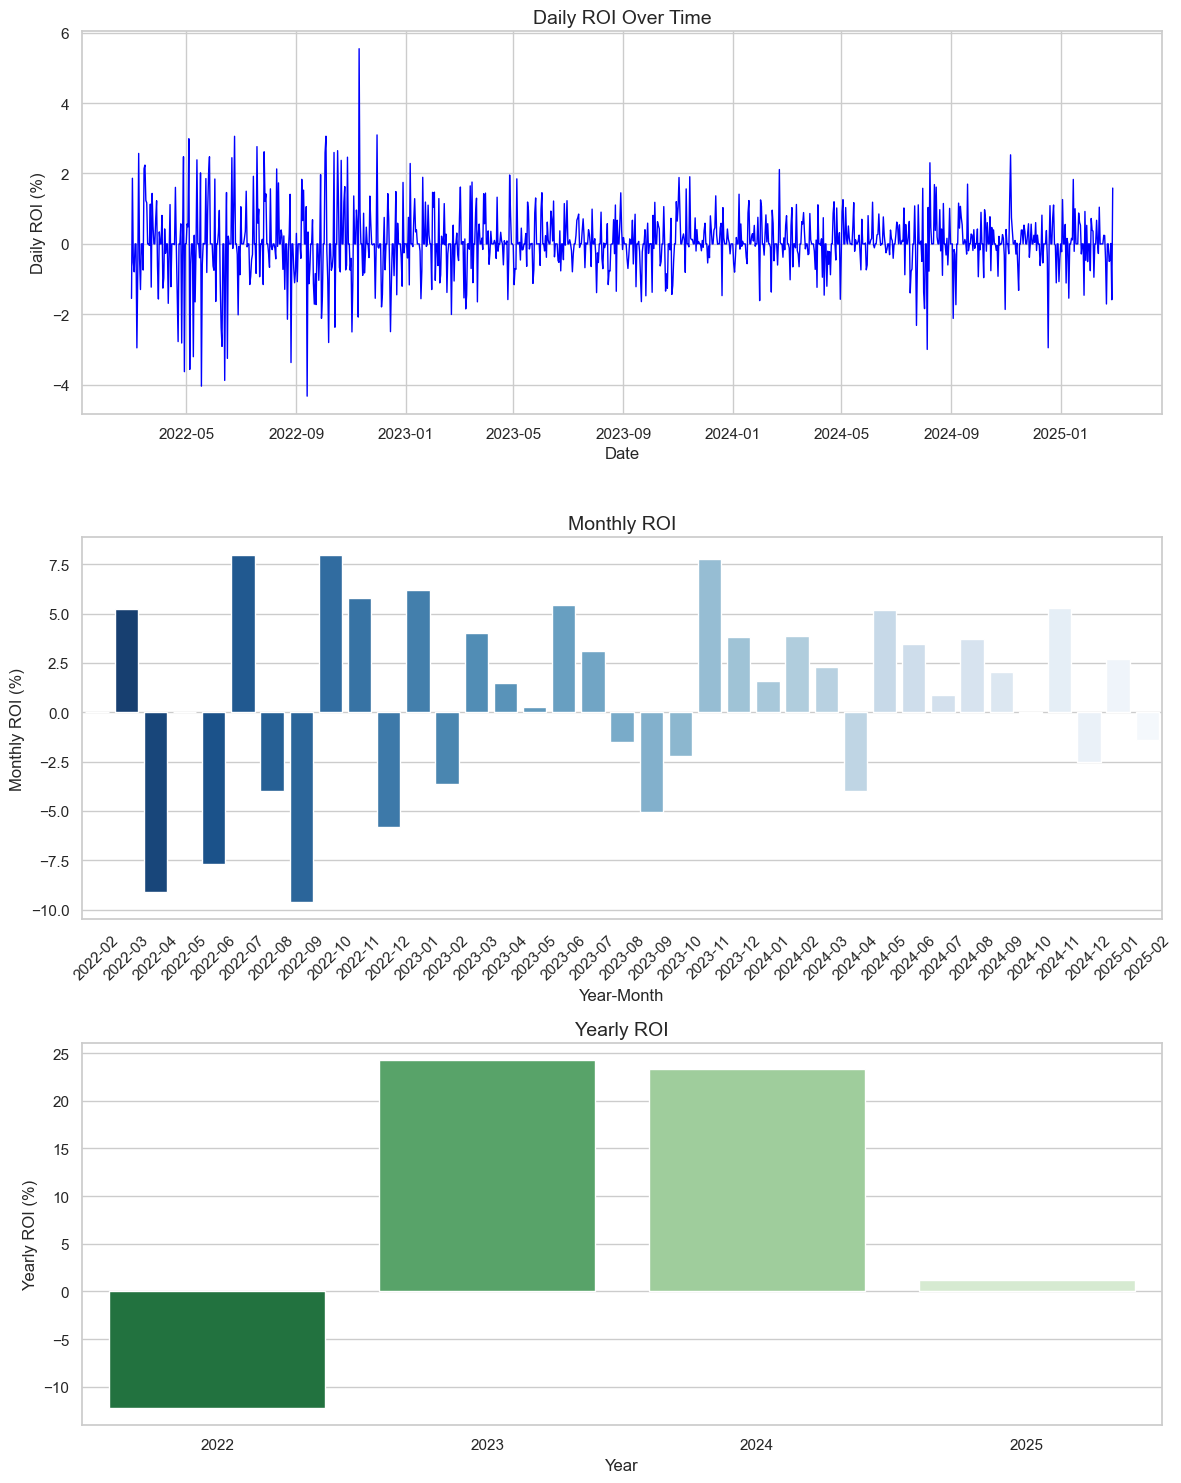

Total ROI: 36.14%
Annualized ROI: 10.83%


In [18]:
visualize_roi(spx_roi)

#### Answer: In the long run, the ROI of the S&P 500 outperforms that of Ethereum. In the short term, the ROI of the S&P 500 is also less volatile compared to Ethereum. Therefore, as an investor seeking stable returns, I would choose to invest in stock, as it offers better long-term returns and more stable performance.

## Q2. When to invest? Is there any seasonality for cryptocurrency and stock? For instance, should you wait for a specific month before starting to invest?

#### Process Ethereum and S&P 500 data by calculating daily returns, volatility, and time-related features. Compute future 30-day returns as the target variable and creates a binary classification label (1 for positive returns, 0 for negative).
#### The data is standardized and split into training and test sets for model evaluation

In [19]:
# Sort the data by date
ethereum1 = ethereum.sort_values(by='date').reset_index(drop=True)
spx1 = spx.sort_values(by='date').reset_index(drop=True)

# Calculate the daily returns (percentage change)
ethereum1['daily_return'] = ethereum1['price'].pct_change()
spx1['daily_return'] = spx1['price'].pct_change()

# Calculate the rolling 30-day volatility (standard deviation of daily returns)
ethereum1['volatility'] = ethereum1['daily_return'].rolling(window=30).std()
spx1['volatility'] = spx1['daily_return'].rolling(window=30).std()

# Extract time-related features
for df in [ethereum1, spx1]:
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.weekday   # Monday=0, Sunday=6
    df['quarter'] = df['date'].dt.quarter
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)

# Compute the future 30-day return as our target variable
ethereum1['future_return'] = (ethereum1['price'].shift(-30) - ethereum1['price']) / ethereum['price']
spx1['future_return'] = (spx1['price'].shift(-30) - spx1['price']) / spx1['price']

# Define the binary classification target: 1 if future return is positive, 0 otherwise
ethereum1['label'] = (ethereum1['future_return'] > 0).astype(int)
spx1['label'] = (spx1['future_return'] > 0).astype(int)

# Select features for the model
features = ['month', 'day_of_week', 'quarter', 'is_year_end', 'is_month_start', 'daily_return', 'volatility']
X_eth = ethereum1[features].dropna()  # Drop missing values generated by calculations
y_eth = ethereum1['label'][X_eth.index]

X_spx = spx1[features].dropna()
y_spx = spx1['label'][X_spx.index]

# Standardize the features for SVM
scaler = StandardScaler()
X_eth_scaled = scaler.fit_transform(X_eth)
X_spx_scaled = scaler.fit_transform(X_spx)

# Split the data into training and test sets
X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(X_eth_scaled, y_eth, test_size=0.2, random_state=42)
X_train_spx, X_test_spx, y_train_spx, y_test_spx = train_test_split(X_spx_scaled, y_spx, test_size=0.2, random_state=42)

#### Identify the most accurate SVM model settings for both datasets,using GridSearchCV.

In [20]:
# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel types
}

# Initialize base SVM model
svm_model = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search_eth = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_spx = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV for Ethereum and S&P 500 datasets
grid_search_eth.fit(X_train_eth, y_train_eth)
grid_search_spx.fit(X_train_spx, y_train_spx)

# Get best parameters and best score for Ethereum
print("Best parameters for Ethereum:", grid_search_eth.best_params_)
print("Best accuracy for Ethereum:", grid_search_eth.best_score_)

# Get best parameters and best score for S&P 500
print("Best parameters for S&P 500:", grid_search_spx.best_params_)
print("Best accuracy for S&P 500:", grid_search_spx.best_score_)


Best parameters for Ethereum: {'C': 10, 'gamma': 1, 'kernel': 'poly'}
Best accuracy for Ethereum: 0.7102555509007121
Best parameters for S&P 500: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best accuracy for S&P 500: 0.678796009631923


### USe SVM models on predicting positive future returns for Ethereum and S&P 500

In [21]:
# Train an SVM classifier using the RBF kernel
svm_eth = SVC(kernel='poly', C=10.0, gamma=1)
svm_spx = SVC(kernel='rbf', C=100.0, gamma='auto')

svm_eth.fit(X_train_eth, y_train_eth)
svm_spx.fit(X_train_spx, y_train_spx)

# Predict on the test sets
y_pred_eth = svm_eth.predict(X_test_eth)
y_pred_spx = svm_spx.predict(X_test_spx)

# Evaluate the models
accuracy_eth = accuracy_score(y_test_eth, y_pred_eth)
accuracy_spx = accuracy_score(y_test_spx, y_pred_spx)

print(f"Ethereum SVM classification accuracy: {accuracy_eth:.2f}")
print(f"S&P 500 SVM classification accuracy: {accuracy_spx:.2f}")

print("\nEthereum Classification Report:")
print(classification_report(y_test_eth, y_pred_eth))

print("\nS&P 500 Classification Report:")
print(classification_report(y_test_spx, y_pred_spx))

Ethereum SVM classification accuracy: 0.69
S&P 500 SVM classification accuracy: 0.68

Ethereum Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       100
           1       0.69      0.66      0.67        94

    accuracy                           0.69       194
   macro avg       0.69      0.69      0.69       194
weighted avg       0.69      0.69      0.69       194


S&P 500 Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.42      0.47        72
           1       0.73      0.82      0.77       142

    accuracy                           0.68       214
   macro avg       0.63      0.62      0.62       214
weighted avg       0.67      0.68      0.67       214



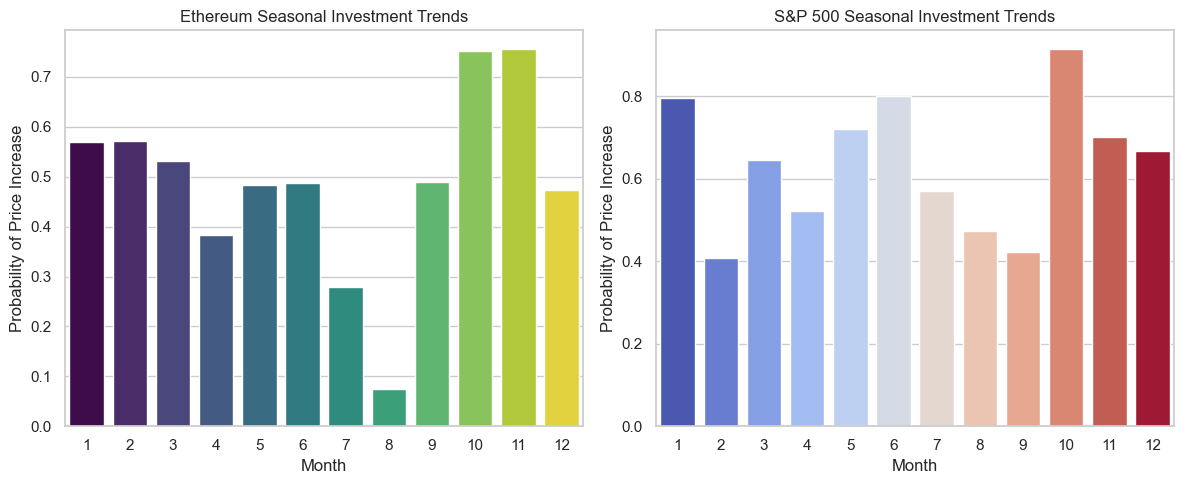

In [22]:
# Visualize seasonal trends: Average probability of a price increase by month
monthly_trend_eth = ethereum1.groupby('month')['label'].mean()
monthly_trend_spx = spx1.groupby('month')['label'].mean()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=monthly_trend_eth.index, y=monthly_trend_eth.values, hue=monthly_trend_eth.index, palette="viridis", legend=False)
plt.xlabel("Month")
plt.ylabel("Probability of Price Increase")
plt.title("Ethereum Seasonal Investment Trends")

plt.subplot(1, 2, 2)
sns.barplot(x=monthly_trend_spx.index, y=monthly_trend_spx.values, hue=monthly_trend_spx.index, palette="coolwarm", legend=False)
plt.xlabel("Month")
plt.ylabel("Probability of Price Increase")
plt.title("S&P 500 Seasonal Investment Trends")

plt.tight_layout()
plt.show()

#### Answer： Yes, there is seasonality both in cryptocurrency and stock. I should wait for a specific month before starting to invest to get a highr probability to earn more profit. If I invest cryptocurrency, I will choose to invest it on October and November because the probability of price increase is higher than other months. For stock, I will choose October.

## Q3. Whether to use a pure or hybrid strategy (means split investment approach X% in cryptocur- rency or Y% in stock)?

#### Train Random Forest model to predict portfolio returns and evaluates it using Mean Squared Error. 
#### Optimize the asset allocation to maximize the Sharpe Ratio, identifying the best allocation for a balanced risk-return profile.

In [23]:
# Merge both datasets on date
df = pd.merge(ethereum, spx, on="date", suffixes=("_eth", "_spx"))

# Calculate daily returns for Ethereum and S&P 500
df['return_eth'] = df['price_eth'].pct_change()  # Ethereum returns
df['return_spx'] = df['price_spx'].pct_change()  # S&P 500 returns

# Drop NaN values (due to pct_change() in the first row)
df = df.dropna()

# Create different asset allocation combinations (e.g., 0% ETH - 100% SPX, 50%-50%, 100% ETH - 0% SPX)
allocation_ratios = np.linspace(0, 1, 11)  # 0%, 10%, ..., 100% Ethereum

# Generate synthetic dataset with different allocations
allocation_data = []
for ratio in allocation_ratios:
    df["portfolio_return"] = df["return_eth"] * ratio + df["return_spx"] * (1 - ratio)
    df["portfolio_volatility"] = np.sqrt((df["return_eth"]**2 * ratio**2) + 
                                         (df["return_spx"]**2 * (1 - ratio)**2) +
                                         (2 * df["return_eth"] * df["return_spx"] * ratio * (1 - ratio)))
    
    for i in range(len(df)):
        allocation_data.append([
            df.iloc[i]['date'], 
            df.iloc[i]['return_eth'], 
            df.iloc[i]['return_spx'], 
            ratio, 
            df.iloc[i]['portfolio_return'],
            df.iloc[i]['portfolio_volatility']
        ])

# Convert to DataFrame
columns = ["date", "return_eth", "return_spx", "eth_allocation", "portfolio_return", "portfolio_volatility"]
df_alloc = pd.DataFrame(allocation_data, columns=columns)

# Prepare features and target variable
X = df_alloc.drop(columns=["portfolio_return", "portfolio_volatility", "date"])  # Features
y = df_alloc["portfolio_return"]  # Target: portfolio return

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.6f}")

# Find the best allocation based on Sharpe Ratio
allocation_range = np.linspace(0, 1, 101)  # Test finer splits (0% to 100%)
best_allocation = None
best_sharpe_ratio = -np.inf

for alloc in allocation_range:
    # Use average returns and volatility as an example input (using historical mean)
    test_input = pd.DataFrame([[df['return_eth'].mean(), df['return_spx'].mean(), alloc]], 
                              columns=["return_eth", "return_spx", "eth_allocation"])
    
    predicted_return = rf_model.predict(test_input)[0]  # Predict portfolio return
    
    # Estimate portfolio volatility for this allocation
    portfolio_volatility = np.sqrt(
        (df['return_eth'].std()**2 * alloc**2) + 
        (df['return_spx'].std()**2 * (1 - alloc)**2) +
        (2 * df['return_eth'].corr(df['return_spx']) * df['return_eth'].std() * df['return_spx'].std() * alloc * (1 - alloc))
    )

    # Compute Sharpe Ratio (assuming risk-free rate = 0)
    sharpe_ratio = predicted_return / portfolio_volatility if portfolio_volatility != 0 else 0

    if sharpe_ratio > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio
        best_allocation = alloc

print(f"Best Ethereum Allocation (Max Sharpe Ratio): {best_allocation * 100:.2f}%")
print(f"Expected Portfolio Return: {predicted_return*100:.6f}%")
print(f"Expected Portfolio Volatility: {portfolio_volatility*100:.6f}%")
print(f"Max Sharpe Ratio: {best_sharpe_ratio:.6f}")


Mean Squared Error: 0.000003
Best Ethereum Allocation (Max Sharpe Ratio): 15.00%
Expected Portfolio Return: 0.080966%
Expected Portfolio Volatility: 3.463439%
Max Sharpe Ratio: 0.030712


#### Answer: Based on the calculated results, it is recommended to adopt a hybrid investment strategy, allocating 15% of the total investment to Ethereum and 85% to stocks. This allocation is expected to offer a more favorable balance between potential returns and volatility, optimizing the portfolio's risk-return profile.

## Q4. What should be the investment horizon (how long: months or years)?


#### Implements a sliding window approach to forecast future returns for both Ethereum and the S&P 500 over different time horizons.

#### 1.Sliding Window Dataset Creation: The code defines a function to create datasets by using the past 90 days returns to predict the sum of returns over a given future period. This is done for multiple horizons: 1 month, 3 months, 6 months, 1 year, and 2 years.

#### 2. Model Training: For each asset (Ethereum and S&P 500), the dataset is split into training and test sets. An XGBoost Regressor model is then trained to predict future returns. The model's performance is evaluated using Mean Squared Error (MSE).

#### 3.Future Predictions: After training, the model is used to predict future returns (from 2025 to 2028) for each asset, based on the most recent data. The predictions are plotted to visualize how the model forecasts returns over time.

Training models for Ethereum.

Ethereum - Investment Horizon: 1 months - MSE: 0.028138
Ethereum - Investment Horizon: 3 months - MSE: 0.055801
Ethereum - Investment Horizon: 6 months - MSE: 0.060948
Ethereum - Investment Horizon: 12 months - MSE: 0.040750
Ethereum - Investment Horizon: 24 months - MSE: 0.060711
Training models for S&P 500.

S&P 500 - Investment Horizon: 1 months - MSE: 0.001729
S&P 500 - Investment Horizon: 3 months - MSE: 0.002443
S&P 500 - Investment Horizon: 6 months - MSE: 0.002717
S&P 500 - Investment Horizon: 12 months - MSE: 0.003688
S&P 500 - Investment Horizon: 24 months - MSE: 0.005340


<Figure size 1200x600 with 0 Axes>

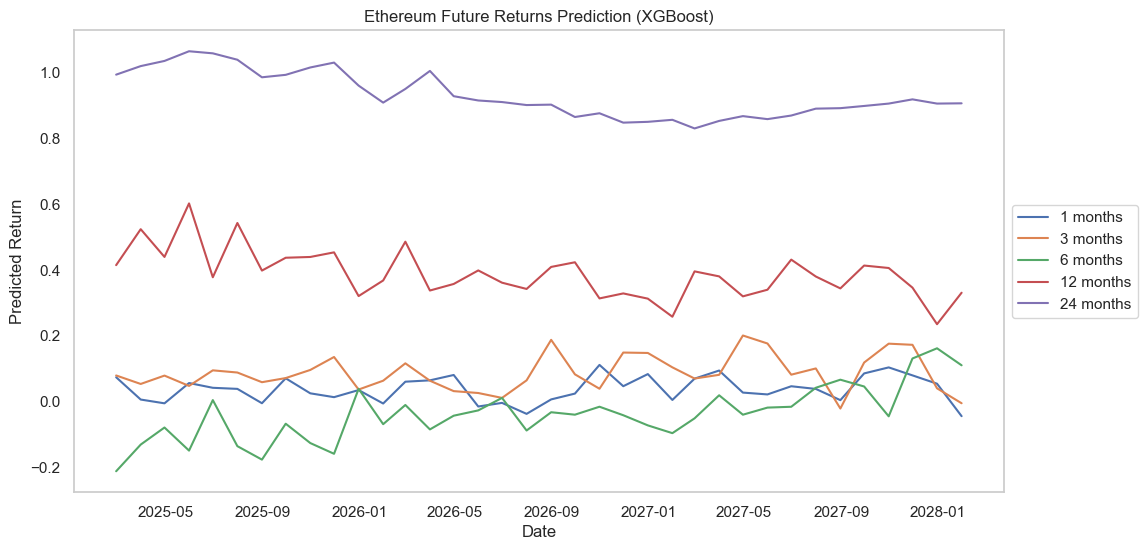

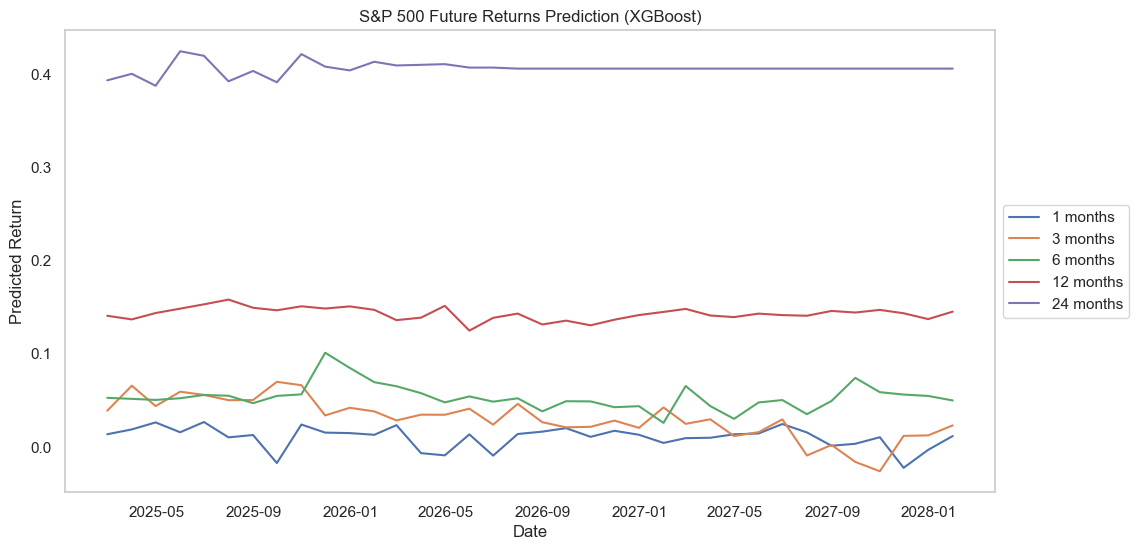

In [24]:
ethereum2 = ethereum.copy()
spx2 = spx.copy()

ethereum2['daily_return'] = ethereum2['price'].pct_change()
spx2['daily_return'] = spx2['price'].pct_change()
ethereum2 = ethereum2.dropna().reset_index(drop=True)
spx2 = spx2.dropna().reset_index(drop=True)

# Function to create dataset with sliding window approach
def create_dataset(df, target_col, past_days, future_days):
    X, y = [], []
    for i in range(len(df) - past_days - future_days):
        X.append(df[target_col].iloc[i:i+past_days].values)  # Past `past_days` returns
        future_return = df[target_col].iloc[i+past_days:i+past_days+future_days].sum()  # Total return over `future_days`
        y.append(future_return)
    return np.array(X), np.array(y)

past_days = 90  # Use past 30 days as features
future_days_options = [30, 90, 180, 365, 730]  # Predict for 1M, 3M, 6M, 1Y, 2Y

# Train models separately for Ethereum and S&P 500
models = {}
datasets = {}

for asset_name, df in [("Ethereum", ethereum2), ("S&P 500", spx2)]:
    print(f"Training models for {asset_name}.\n")
    datasets[asset_name] = {}

    for future_days in future_days_options:
        X, y = create_dataset(df, "daily_return", past_days, future_days)
        datasets[asset_name][future_days] = (X, y)

        # Split dataset into train/test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train XGBoost Regressor
        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate performance
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"{asset_name} - Investment Horizon: {future_days//30} months - MSE: {mse:.6f}")

        models[(asset_name, future_days)] = model

# Predict Future Returns (for 2025-2028)
future_dates = pd.date_range(ethereum2["date"].max(), periods=36, freq="ME")  # Next 3 years (monthly)
predictions = {asset_name: {horizon: [] for horizon in future_days_options} for asset_name in ["Ethereum", "S&P 500"]}

for asset_name, df in [("Ethereum", ethereum2), ("S&P 500", spx2)]:
    last_inputs = df["daily_return"].iloc[-past_days:].values.reshape(1, -1)

    for horizon, model in models.items():
        if horizon[0] == asset_name:  # Ensure we use the correct model
            for _ in range(len(future_dates)):
                pred = model.predict(last_inputs)[0]
                predictions[asset_name][horizon[1]].append(pred)
                last_inputs = np.roll(last_inputs, -1)
                last_inputs[0, -1] = pred  # Add new prediction

# Visualize Predictions
plt.figure(figsize=(12, 6))
for asset_name in ["Ethereum", "S&P 500"]:
    plt.figure(figsize=(12, 6))
    for horizon, preds in predictions[asset_name].items():
        plt.plot(future_dates, preds, label=f"{horizon//30} months")

    plt.title(f"{asset_name} Future Returns Prediction (XGBoost)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Return")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.show()


#### Answer: Based on the charts above, long-term investments (spanning several years) are expected to yield significantly higher returns compared to shorter-term monthly investments. Therefore, a long-term investment horizon (measured in years) is recommended for better growth potential.